In [29]:
# La libreria keras es la que se usa por defecto para redes neuronales
# Nota: Es necesario tambien instalar la libreria tensorflow para no tener problemas con el codigo
# Seguramente para una version de python por encima de la 3.6 existan problemas...
# .... para ello usar este comando: pip3 install --upgrade tensorflow-gpu

from tensorflow.python.keras import optimizers
from keras.layers import Input, Dense
from keras import regularizers, models, optimizers

# Comando adicional, es necesario instalar esta libreria para que trabaje bien
# Dado que optimizers nos ofrece es la segunda version de Adam
#from tensorflow.python.keras.optimizer_v2.adam import Adam


from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

# Lectura de dataset

In [18]:
# Excel que contiene las curvas yield
df = pd.read_csv('base_yields_definitiva_1.csv', sep=',')

In [19]:
df.columns

Index(['Date', '0.1', '0.2', '0.3', '0.4', '0.5', '1', '2', '3', '4', '5', '7',
       '10', '15', '20', '25', '30'],
      dtype='object')

In [20]:
# Transformar el dia a un mejor formato
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

# Colocar los dias como indice de la base de datos
df.set_index('Date', drop=True, inplace=True)

df.index.names = [None]

#df.drop('Index', axis=1, inplace=True)

n_obs = len(df)

In [21]:
df.head()

,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5,7,10,15,20,25,30
1985-12-31,5.296816,5.764847,5.999058,6.033224,6.041467,7.478717,7.851847,8.159471,8.435339,8.623416,8.9347,9.00,9.4652,9.50,9.7107,9.27
1986-01-31,5.400492,5.918933,5.988622,5.979262,6.052656,7.576836,7.827984,8.215499,8.462500,8.643589,9.0268,9.08,9.5591,9.48,9.7600,9.34
1986-02-28,5.375026,5.972349,5.876289,6.026928,6.017642,7.377329,7.544898,7.723332,7.883363,8.029986,8.1907,8.13,8.4619,8.34,8.6182,8.27
1986-03-31,5.224132,5.392745,5.377609,5.356386,5.408022,6.791051,6.827183,7.084252,7.284835,7.376083,7.5020,7.39,7.6828,7.46,7.7668,7.44
1986-04-30,4.544503,5.102897,5.109401,5.228630,5.267526,6.496897,6.701759,7.136291,7.267922,7.398711,7.5389,7.38,7.7621,7.55,7.8903,7.47


# Visualizando los datos

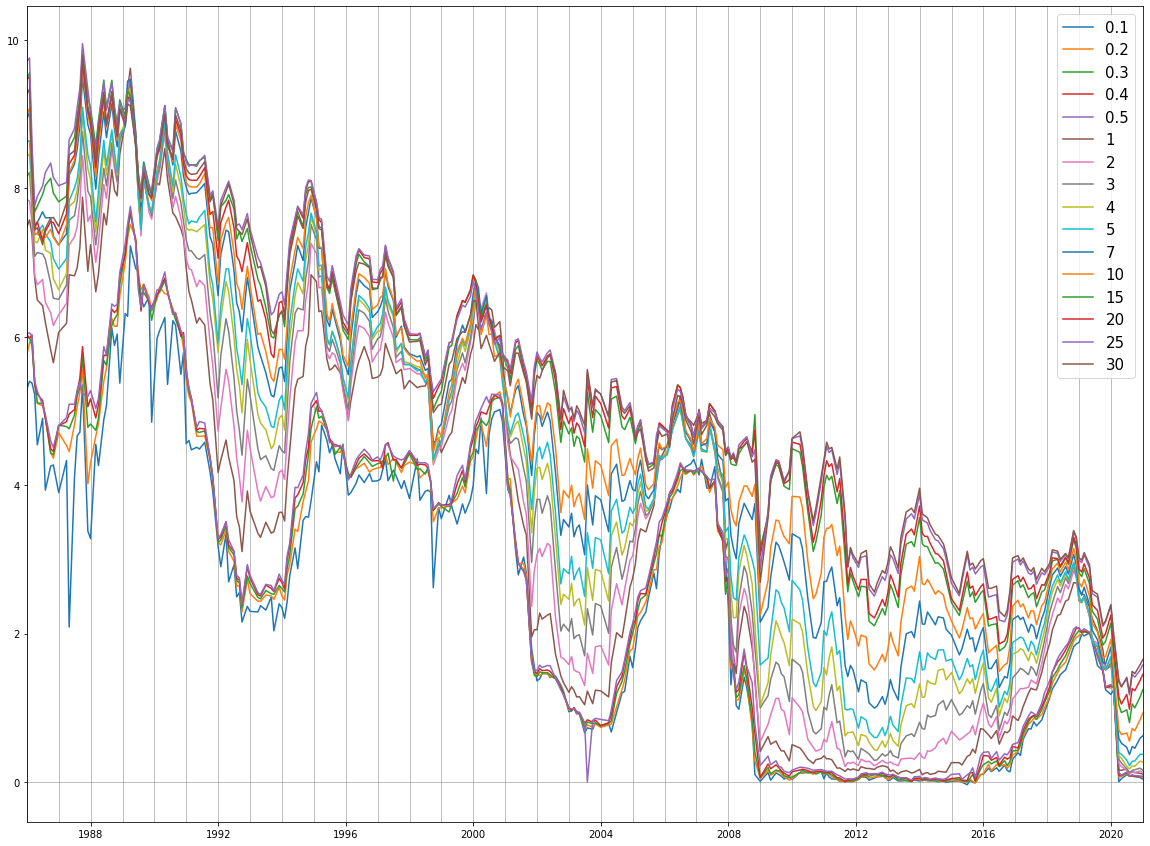

In [22]:
plt.figure(figsize=(20, 15))

plt.plot(df.index, df)

plt.xlim(df.index.min(), df.index.max())
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
plt.legend(df.columns, fontsize=15)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=datetime(i, 1, 1), c="grey", linewidth=0.5, zorder=0)

# Implementacion por PCA

In [23]:
# Se usan los 3 primeros componentes principales
pca_model = PCA(n_components=3, copy=True, whiten=False)
# Se corre el PCA para el data set
pca_model.fit(df)

# Proyectar el dataset en cada uno de los componentes principales
df_pca = pd.DataFrame(pca_model.transform(df), index=df.index)

# En caso de que queramos retornar a las observaciones originales, nos funciona para calcular el error
df_pca_recon = pd.DataFrame(pca_model.inverse_transform(df_pca), index=df.index, columns=df.columns)

# Cada variable por PCA

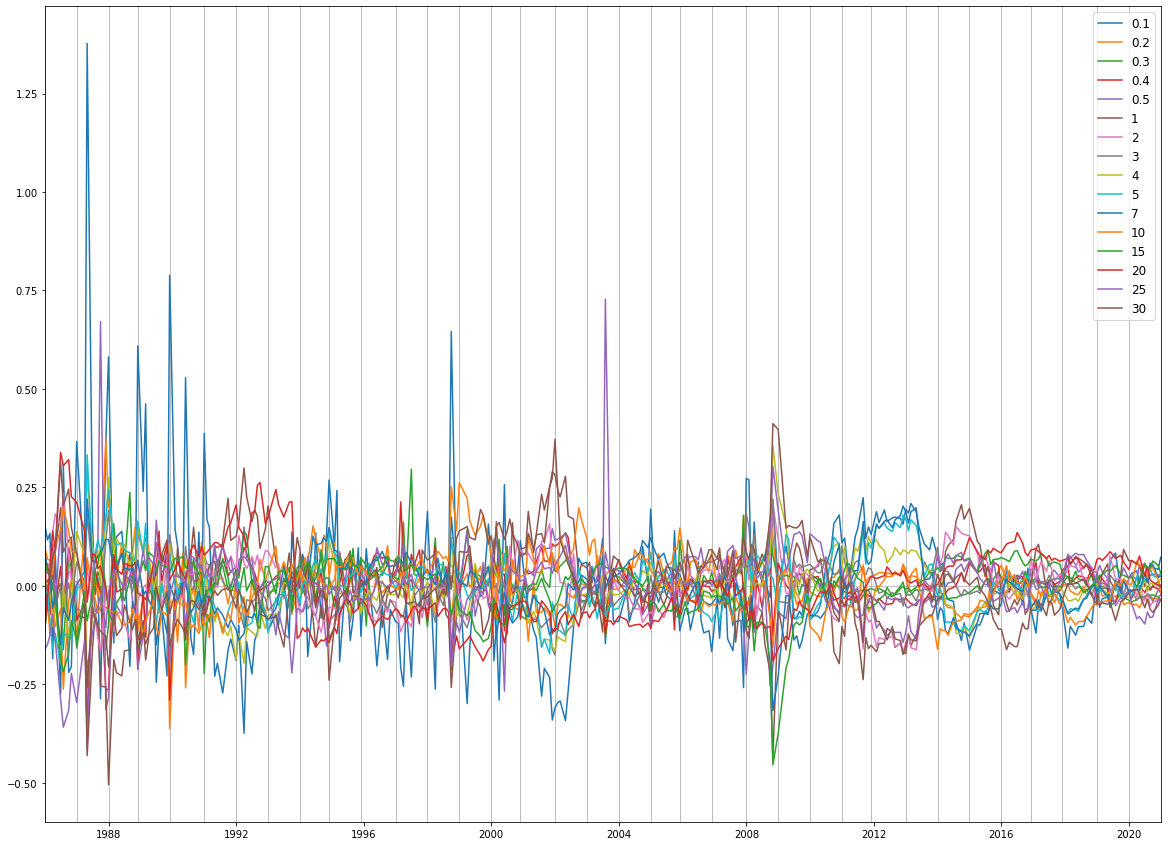

In [24]:
plt.figure(figsize=(20,15))

# Plotting the difference between the reconstructed value and the original
plt.plot(df.index, df_pca_recon-df.values)
plt.xlim(df.index.min(), df.index.max())
plt.legend(df.columns, fontsize=12)
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)

In [25]:
# Evaluando cuanto explica cada componente
for i, pc in enumerate(pca_model.explained_variance_ratio_):
    print('PC {0}:\t{1:5.2f}%'.format(i+1, pc*100.0))

PC 1:	95.48%
PC 2:	 4.10%
PC 3:	 0.28%


# Vectores de carga

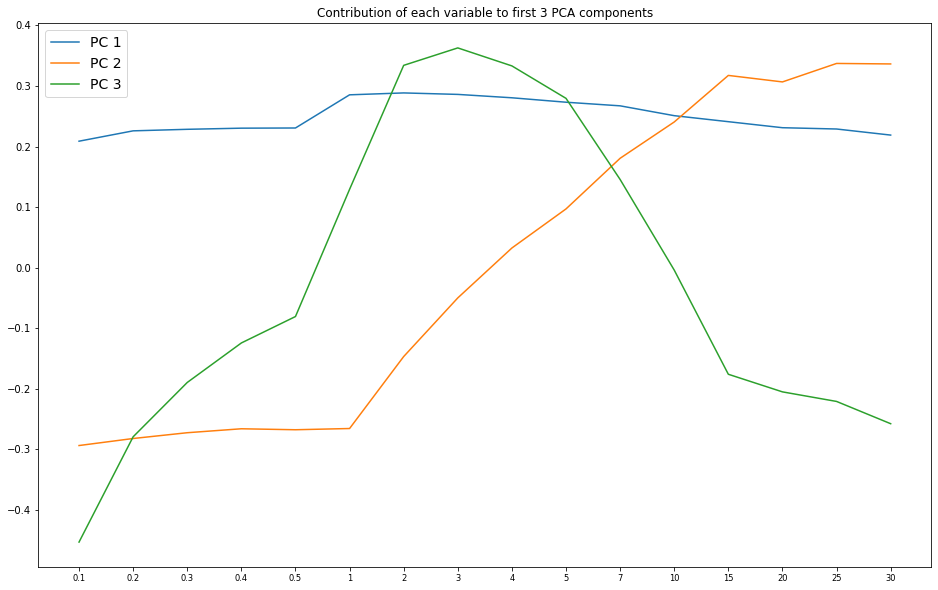

In [26]:
fig = plt.figure(figsize=(16,10))
plt.title('Contribution of each variable to first {0} PCA components'.format(pca_model.n_components))

plt.plot(np.transpose(pca_model.components_[0]), label='PC 1')
plt.plot(np.transpose(pca_model.components_[1]), label='PC 2')
plt.plot(np.transpose(pca_model.components_[2]), label='PC 3')
plt.xticks(range(len(df.columns)), df.columns, size='small')

plt.legend(fontsize=14);

# Autoencoder lineal

In [27]:
def LinearAE(y, dimension, learning_rate = 1e-4, regularization = 1e-5, epochs=10):
    
    input_layer = Input(shape=(y.shape[1],))
    
    # the encoder layer transforms the input into a representation of size `dimension`
    encoder = Dense(dimension, activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(input_layer)
    
    # the decoder layer transforms the encoded representation back to the original size
    decoder = Dense(y.shape[1], activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(encoder)
    
    adam=Adam(lr=learning_rate)
    autoencoder = models.Model(input_layer, decoder)
    autoencoder.compile(optimizer=optimizers.adam_v2.Adam(lr=learning_rate), loss='mean_squared_error')
    
    # the autoencoder aims to map the input back onto 
    # itself: the input data are also the output targets
    autoencoder.fit(y, y, epochs=epochs, batch_size=4, shuffle=True)
    
    return autoencoder

In [31]:
ae_model = LinearAE(df.values, 3, regularization=0, epochs=2000)

Epoch 1/2000
75/75 [==============================] - 3s 3ms/step - loss: 22.2452
Epoch 2/2000
75/75 [==============================] - 0s 2ms/step - loss: 20.2370
Epoch 3/2000
75/75 [==============================] - 0s 2ms/step - loss: 16.0843
Epoch 4/2000
75/75 [==============================] - 0s 2ms/step - loss: 16.3281
Epoch 5/2000
75/75 [==============================] - 0s 3ms/step - loss: 15.5163
Epoch 6/2000
75/75 [==============================] - 0s 2ms/step - loss: 16.5206
Epoch 7/2000
75/75 [==============================] - 0s 2ms/step - loss: 14.2648
Epoch 8/2000
75/75 [==============================] - 0s 2ms/step - loss: 13.1623
Epoch 9/2000
75/75 [==============================] - 0s 2ms/step - loss: 13.0340
Epoch 10/2000
75/75 [==============================] - 0s 2ms/step - loss: 12.2640
Epoch 11/2000
75/75 [==============================] - 0s 2ms/step - loss: 11.6301
Epoch 12/2000
75/75 [==============================] - 0s 3ms/step - loss: 11.8345
Epoch 13/2000

75/75 [==============================] - 0s 2ms/step - loss: 0.1740
Epoch 199/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.1691
Epoch 200/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.1742
Epoch 201/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.1713
Epoch 202/2000
75/75 [==============================] - 0s 3ms/step - loss: 0.1659
Epoch 203/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.1598
Epoch 204/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.1577
Epoch 205/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.1671
Epoch 206/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.1668
Epoch 207/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.1583A: 0s - loss: 0.158
Epoch 208/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.1674
Epoch 209/2000
75/75 [==============================] - 0s 3ms/step - loss: 0.1614


75/75 [==============================] - 0s 2ms/step - loss: 0.0284
Epoch 395/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0312
Epoch 396/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0318
Epoch 397/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0310
Epoch 398/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0291
Epoch 399/2000
75/75 [==============================] - 0s 3ms/step - loss: 0.0286
Epoch 400/2000
75/75 [==============================] - 0s 5ms/step - loss: 0.0303
Epoch 401/2000
75/75 [==============================] - 0s 3ms/step - loss: 0.0289
Epoch 402/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0299
Epoch 403/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0276
Epoch 404/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0301
Epoch 405/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0300
Epoch 406/2000
75/7

75/75 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 591/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0236
Epoch 592/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0233
Epoch 593/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 594/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0240
Epoch 595/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0228
Epoch 596/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 597/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0233
Epoch 598/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 599/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0277
Epoch 600/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0250
Epoch 601/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0259
Epoch 602/2000
75/7

75/75 [==============================] - 0s 3ms/step - loss: 0.0226
Epoch 786/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0222
Epoch 787/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 788/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 789/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 790/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 791/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 792/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0250
Epoch 793/2000
75/75 [==============================] - 0s 3ms/step - loss: 0.0226
Epoch 794/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0232
Epoch 795/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 796/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 797/2000
75/7

75/75 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 982/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 983/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 984/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 985/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 986/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 987/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 988/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 989/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 990/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 991/2000
75/75 [==============================] - 0s 3ms/step - loss: 0.0215
Epoch 992/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 993/2000
75/7

75/75 [==============================] - 0s 2ms/step - loss: 0.0241
Epoch 1176/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 1177/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0219
Epoch 1178/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 1179/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 1180/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0258
Epoch 1181/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 1182/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 1183/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0222
Epoch 1184/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 1185/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 1186/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 11

75/75 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 1370/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 1371/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0218
Epoch 1372/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 1373/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 1374/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 1375/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 1376/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 1377/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 1378/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 1379/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 1380/2000
75/75 [==============================] - 0s 3ms/step - loss: 0.0215
Epoch 13

75/75 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 1563/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 1564/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 1565/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 1566/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0190
Epoch 1567/2000
75/75 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 1568/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0177
Epoch 1569/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 1570/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 1571/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 1572/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 1573/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 15

75/75 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 1756/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 1757/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 1758/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 1759/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 1760/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 1761/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 1762/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 1763/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 1764/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 1765/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 1766/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 17

75/75 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 1950/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 1951/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 1952/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 1953/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 1954/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 1955/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0153
Epoch 1956/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 1957/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 1958/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 1959/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 1960/2000
75/75 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 19

In [32]:
(w1, b1, w2, b2) = ae_model.get_weights()

# Vectores singulares

In [33]:
(ae_decoder_lsv, _, _) = np.linalg.svd(w2.T, full_matrices=False)

In [34]:
mu = np.mean(df.values, axis=0)
ae_lsv_projections = np.array(df.values-mu) @ ae_decoder_lsv

In [35]:
df_ae = pd.DataFrame(ae_lsv_projections, index=df.index)

# Covarianzas

In [36]:
C = np.dot((df-mu).T, df-mu)

In [37]:
total_variance = np.sum(np.diag(C))
print('total variance:', total_variance)

total variance: 25318.14094093152


In [38]:
Lambda_from_pca = pca_model.components_ @ C @ pca_model.components_.T

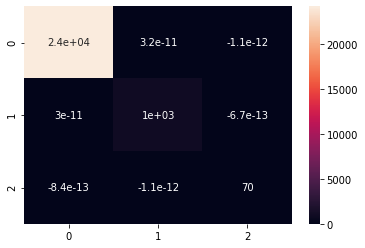

In [39]:
ax = sns.heatmap(Lambda_from_pca, annot=True)

In [40]:
print(100 * np.diag(Lambda_from_pca) / total_variance)
print('{:.6}% of total variance explained'.format(100 * np.sum(np.diag(Lambda_from_pca)) / total_variance))

[95.4771716   4.09755346  0.27722453]
99.8519% of total variance explained


In [41]:
Lambda_from_decoder_weights = w2 @ C @ w2.T

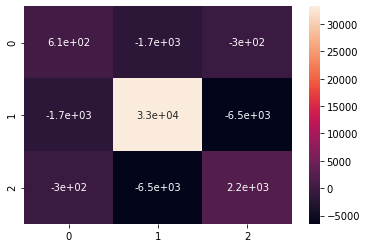

In [42]:
ax = sns.heatmap(Lambda_from_decoder_weights, annot=True)
plt.show()

In [43]:
Lambda_from_decoder_lsv = ae_decoder_lsv.T @ C @ ae_decoder_lsv

In [44]:
print(100*np.diag(Lambda_from_decoder_lsv) / total_variance)
print('{:.6}% of total variance explained'.format(100*np.sum(np.diag(Lambda_from_decoder_lsv)) / total_variance))

[50.06307217  6.01784898 43.63878222]
99.7197% of total variance explained


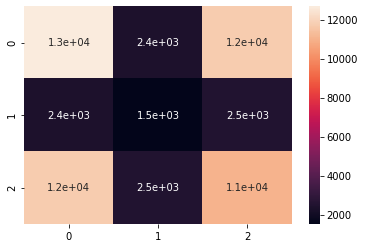

In [45]:
ax = sns.heatmap(Lambda_from_decoder_lsv, annot=True)
plt.show()

# Ajuste del modelo

In [46]:
df_ae_recon = ae_model.predict(df.values)

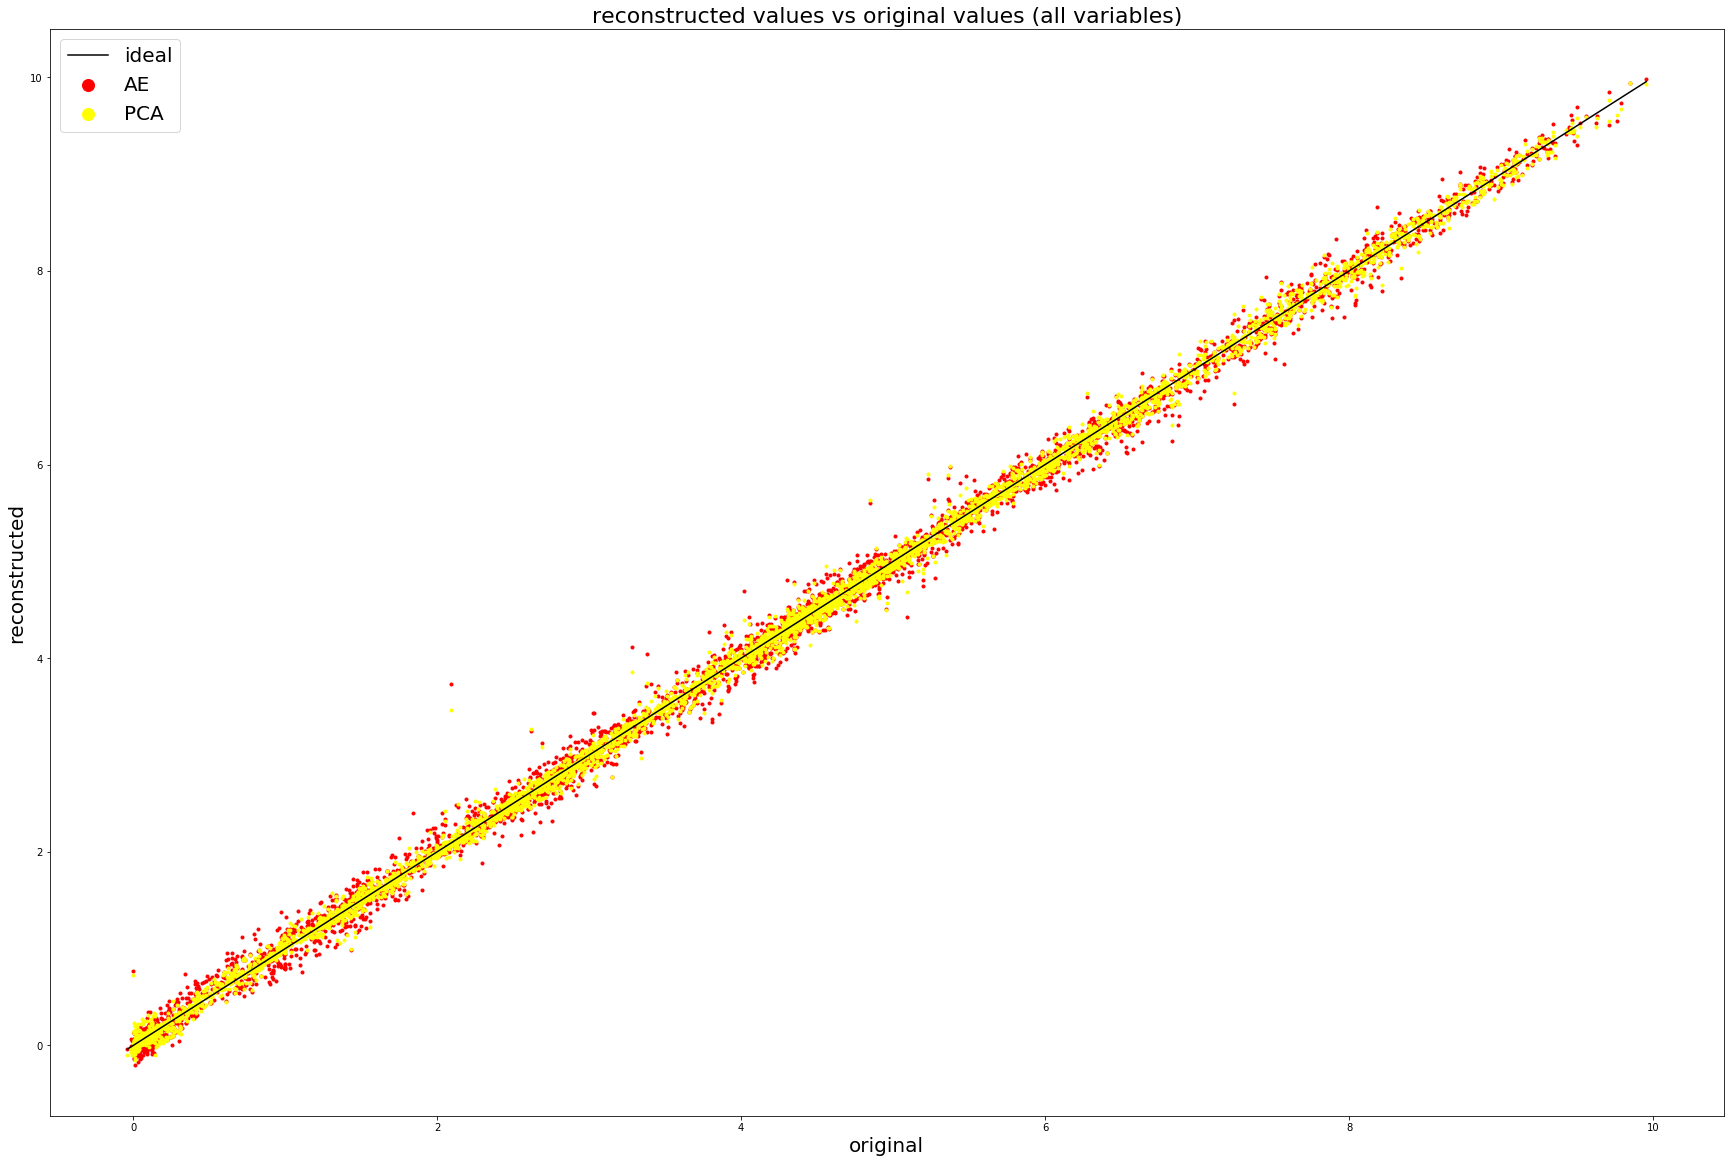

In [47]:
plt.figure(figsize=(30,20))
plt.title('reconstructed values vs original values (all variables)'
         , fontsize=22)
xy = np.linspace(df.values.min(), df.values.max(), 2)

plt.plot(xy, xy, c='black') # y = x
plt.scatter(df.values, df_ae_recon, marker='.', c='red') # ae recon vs original data
plt.scatter(df.values, df_pca_recon, marker='.', c='yellow') # pca preimage vs original data

plt.xlabel('original', fontsize=20)
plt.ylabel('reconstructed', fontsize=20)
plt.legend(['ideal', 'AE', 'PCA'], fontsize=20, markerscale=4);

# Grafico visto desde 2 componentes principales

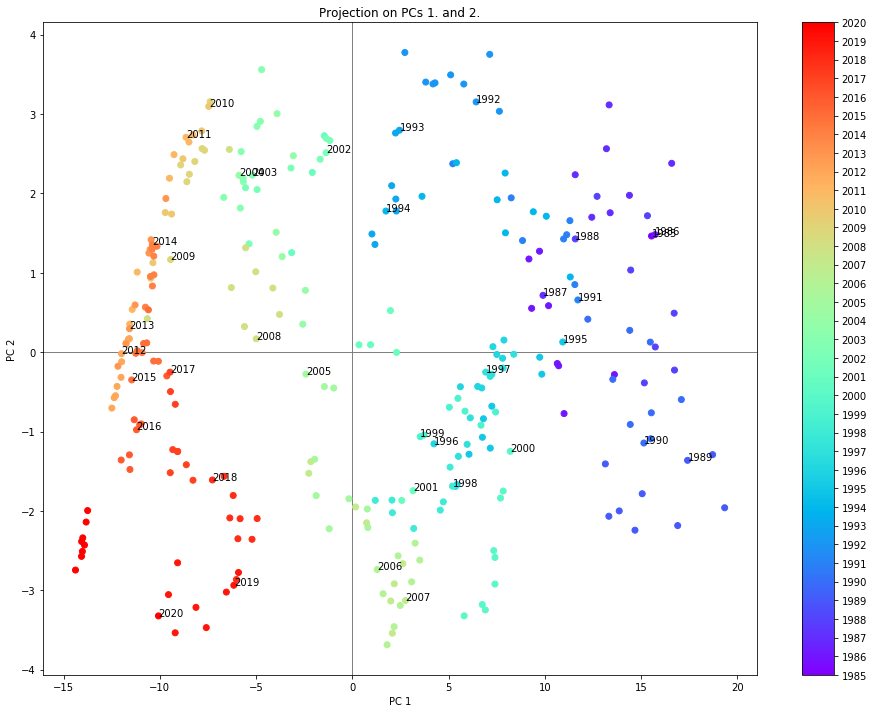

In [48]:
pc1 = 0
pc2 = 1

merged_years = 1

fig = plt.figure(figsize=(16,12))
plt.title('Projection on PCs {0}. and {1}.'.format(pc1+1,pc2+1))
plt.xlabel('PC '+str(pc1+1))
plt.ylabel('PC '+str(pc2+1))
plt.axhline(y=0,c="grey",linewidth=1.0,zorder=0)
plt.axvline(x=0,c="grey",linewidth=1.0,zorder=0)
    
sc = plt.scatter(df_pca.loc[:, pc1], df_pca.loc[:, pc2], c = [d.year for d in df_pca.index], cmap='rainbow')
cb = plt.colorbar(sc)
cb.set_ticks(ticks=np.unique([d.year for d in df_pca.index])[::1])
cb.set_ticklabels(np.unique([d.year for d in df_pca.index])[::1])

for year in range(df_pca.index.min().year, df_pca.index.max().year+1, merged_years):
    year_start = df_pca.index[df_pca.index.searchsorted(datetime(year, 1, 1))]
    year_end = df_pca.index[df_pca.index.searchsorted(datetime(year + merged_years-1, 12, 31))]
    
    plt.annotate('{0}'.format(year), xy=(df_pca.loc[year_start, pc1],df_pca.loc[year_start, pc2]), 
                 xytext=(df_pca.loc[year_start,pc1],df_pca.loc[year_start,pc2]));


# Autoencoders en los componentes

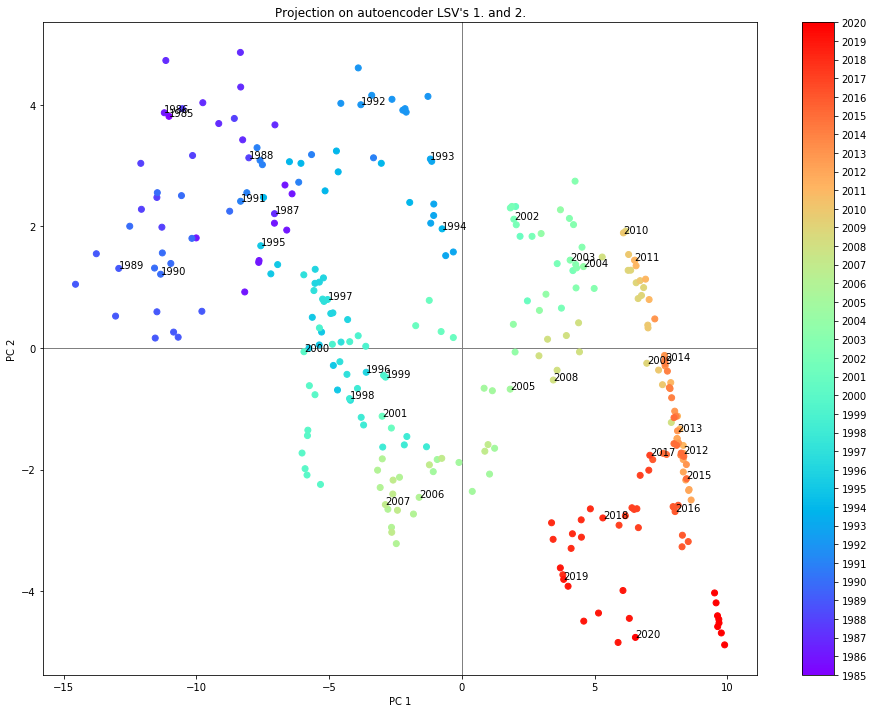

In [49]:
pc1 = 0
pc2 = 1

merged_years = 1
fig = plt.figure(figsize=(16, 12))
plt.title('Projection on autoencoder LSV\'s {0}. and {1}.'.format(pc1+1,pc2+1))
plt.xlabel('PC '+str(pc1+1))
plt.ylabel('PC '+str(pc2+1))
plt.axhline(y=0,c="grey", linewidth=1.0,zorder=0)
plt.axvline(x=0,c="grey", linewidth=1.0,zorder=0)
    
sc = plt.scatter(-df_ae.loc[:,pc1], df_ae.loc[:,pc2], 
                 c=[d.year for d in df_ae.index], cmap='rainbow')
cb = plt.colorbar(sc)
cb.set_ticks(ticks=np.unique([d.year for d in df_ae.index])[::1])
cb.set_ticklabels(np.unique([d.year for d in df_ae.index])[::1])

for year in range(df_ae.index.min().year, df_ae.index.max().year+1, merged_years):
    year_start = df_ae.index[df_ae.index.searchsorted(datetime(year,1,1))]
    year_end = df_ae.index[df_ae.index.searchsorted(datetime(year+merged_years-1,12,31))]
    plt.annotate('{0}'.format(year), xy=(-df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]), 
                 xytext=(-df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]));

# Reconstruccion por variable

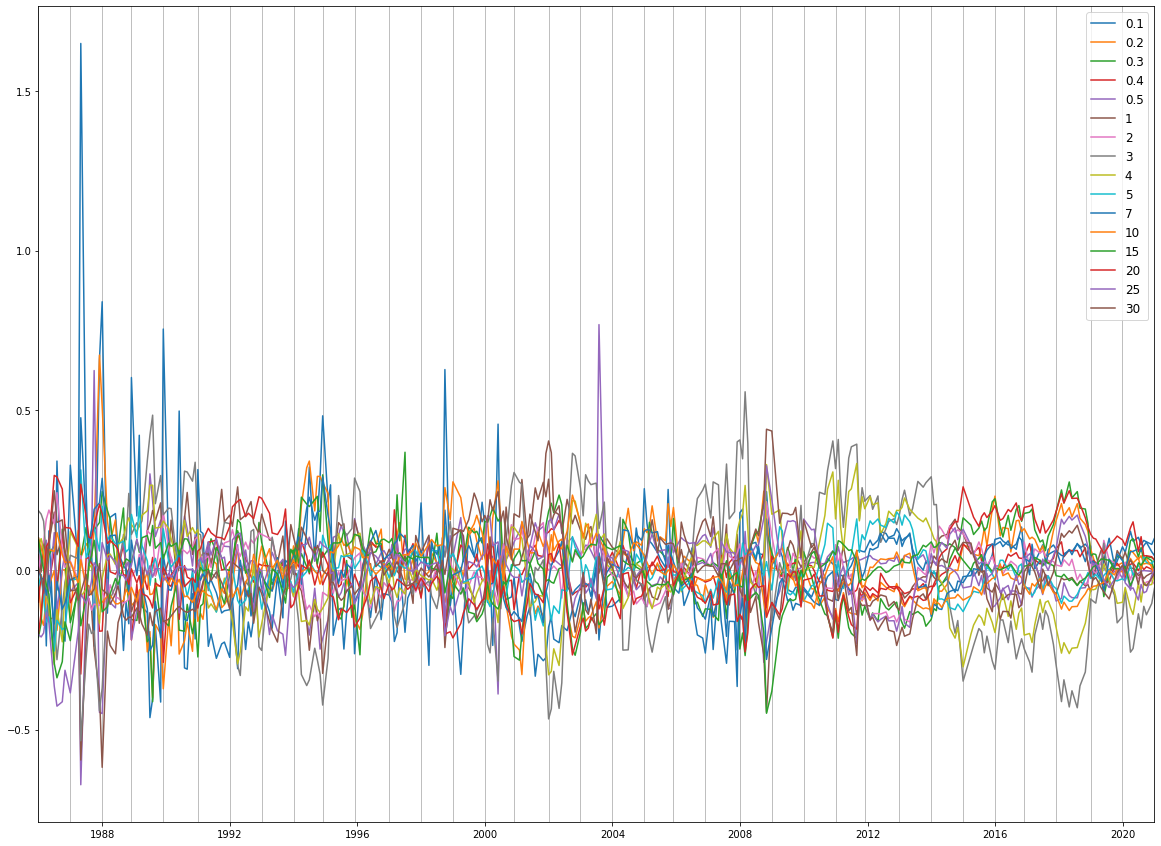

In [50]:
plt.figure(figsize=(20,15))
plt.plot(df.index, pd.DataFrame(df_ae_recon - df))
plt.legend(df.columns, fontsize=12, loc='upper right')
plt.xlim(df.index.min(), df.index.max())
plt.axhline(y=0,c="grey",linewidth=0.5,zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)

# Autoencoder profundo

In [57]:
def DeepAE(y, dimension, learning_rate = 1e-4, regularization = 5e-4, epochs=10):
    input = Input(shape=(y.shape[1],))
    encoded1 = Dense(np.int(2*dimension), activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(input)
    encoded2 = Dense(dimension, activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(encoded1)
    decoded1 = Dense(np.int(y.shape[1]/2), activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(encoded2)
    decoded2 = Dense(y.shape[1], activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(decoded1)
    
    autoencoder = models.Model(input, decoded2)
    autoencoder.compile(optimizer=optimizers.adam_v2.Adam(lr=learning_rate), loss='mean_squared_error')
    
    autoencoder.fit(y, y, epochs=epochs, batch_size=4, shuffle=True)
    
    return autoencoder

In [52]:
deepAE_model = DeepAE(df, 3, regularization=0, epochs=1000)

Epoch 1/1000
75/75 [==============================] - 1s 2ms/step - loss: 21.2425
Epoch 2/1000
75/75 [==============================] - 0s 3ms/step - loss: 21.3734
Epoch 3/1000
75/75 [==============================] - 0s 2ms/step - loss: 20.6914
Epoch 4/1000
75/75 [==============================] - 0s 3ms/step - loss: 19.6904
Epoch 5/1000
75/75 [==============================] - 0s 2ms/step - loss: 19.6026
Epoch 6/1000
75/75 [==============================] - 0s 2ms/step - loss: 19.0766
Epoch 7/1000
75/75 [==============================] - 0s 2ms/step - loss: 18.0792
Epoch 8/1000
75/75 [==============================] - 0s 2ms/step - loss: 19.9245
Epoch 9/1000
75/75 [==============================] - 0s 3ms/step - loss: 17.9012
Epoch 10/1000
75/75 [==============================] - 0s 2ms/step - loss: 19.6846
Epoch 11/1000
75/75 [==============================] - 0s 2ms/step - loss: 18.0860
Epoch 12/1000
75/75 [==============================] - 0s 2ms/step - loss: 18.4629
Epoch 13/1000

Epoch 99/1000
75/75 [==============================] - 0s 3ms/step - loss: 15.2745
Epoch 100/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.2042
Epoch 101/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.8971
Epoch 102/1000
75/75 [==============================] - 0s 3ms/step - loss: 14.8728
Epoch 103/1000
75/75 [==============================] - 0s 3ms/step - loss: 16.4155
Epoch 104/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.7602
Epoch 105/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.0977
Epoch 106/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.7338
Epoch 107/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.2804
Epoch 108/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.5063
Epoch 109/1000
75/75 [==============================] - 0s 2ms/step - loss: 17.5676
Epoch 110/1000
75/75 [==============================] - 0s 2ms/step - loss: 1

75/75 [==============================] - 0s 2ms/step - loss: 16.2091
Epoch 293/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.0499
Epoch 294/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.0005
Epoch 295/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.5384
Epoch 296/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.7086
Epoch 297/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.3150
Epoch 298/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.5846
Epoch 299/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.3378
Epoch 300/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.0324
Epoch 301/1000
75/75 [==============================] - 0s 1ms/step - loss: 15.2036
Epoch 302/1000
75/75 [==============================] - 0s 2ms/step - loss: 16.1691
Epoch 303/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.5422
Epoch 3

75/75 [==============================] - 0s 2ms/step - loss: 14.9107
Epoch 390/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.5366
Epoch 391/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.3764
Epoch 392/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.5533: 0s - loss: 14.
Epoch 393/1000
75/75 [==============================] - 0s 3ms/step - loss: 16.7134
Epoch 394/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.3017
Epoch 395/1000
75/75 [==============================] - 0s 2ms/step - loss: 16.6626
Epoch 396/1000
75/75 [==============================] - 0s 2ms/step - loss: 16.2852: 0s - loss: 16.34
Epoch 397/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.0009
Epoch 398/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.2468
Epoch 399/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.2006
Epoch 400/1000
75/75 [==============================] - 0

75/75 [==============================] - 0s 2ms/step - loss: 14.6146
Epoch 583/1000
75/75 [==============================] - 0s 2ms/step - loss: 13.7188
Epoch 584/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.1138
Epoch 585/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.6886
Epoch 586/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.0722
Epoch 587/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.9022
Epoch 588/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.3618
Epoch 589/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.7880
Epoch 590/1000
75/75 [==============================] - 0s 1ms/step - loss: 15.1966
Epoch 591/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.5914
Epoch 592/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.7627
Epoch 593/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.8515
Epoch 5

Epoch 775/1000
75/75 [==============================] - 0s 2ms/step - loss: 16.4275
Epoch 776/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.2854
Epoch 777/1000
75/75 [==============================] - 0s 2ms/step - loss: 16.0075
Epoch 778/1000
75/75 [==============================] - 0s 2ms/step - loss: 13.5657
Epoch 779/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.8504
Epoch 780/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.2471
Epoch 781/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.7632
Epoch 782/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.3317
Epoch 783/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.7555
Epoch 784/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.0815
Epoch 785/1000
75/75 [==============================] - 0s 1ms/step - loss: 15.6698
Epoch 786/1000
75/75 [==============================] - 0s 2ms/step - loss: 

Epoch 872/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.0061
Epoch 873/1000
75/75 [==============================] - 0s 2ms/step - loss: 13.8108
Epoch 874/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.4798
Epoch 875/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.4062
Epoch 876/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.0735
Epoch 877/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.6487
Epoch 878/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.2436
Epoch 879/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.2218
Epoch 880/1000
75/75 [==============================] - 0s 2ms/step - loss: 16.2508
Epoch 881/1000
75/75 [==============================] - 0s 2ms/step - loss: 14.3697
Epoch 882/1000
75/75 [==============================] - 0s 2ms/step - loss: 15.4246
Epoch 883/1000
75/75 [==============================] - 0s 2ms/step - loss: 

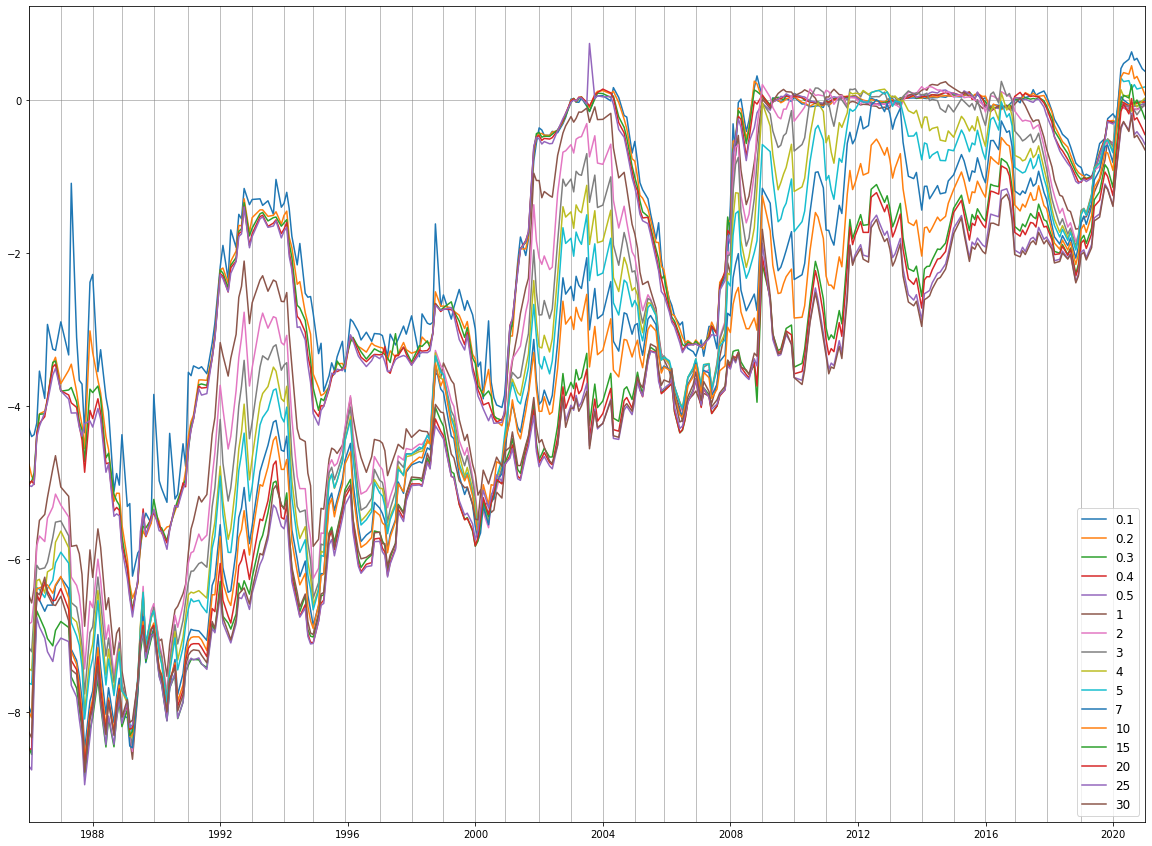

In [54]:
df_deep_recon = deepAE_model.predict(df)

plt.figure(figsize=(20, 15))
plt.plot(df.index, pd.DataFrame(df_deep_recon - df))
plt.xlim(df.index.min(), df.index.max())
plt.legend(df.columns, fontsize=12)
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i, 1, 1)) - 1],
                c="grey", linewidth=0.5, zorder=0)

# Comparacion

In [55]:
pca_rec_errs = np.sqrt(np.sum((df_pca_recon - df)**2, axis=1))

ae_rec_errs = np.sqrt(np.sum((df_ae_recon - df)**2, axis=1))

deep_rec_errs = np.sqrt(np.sum((df_deep_recon - df)**2, axis=1))

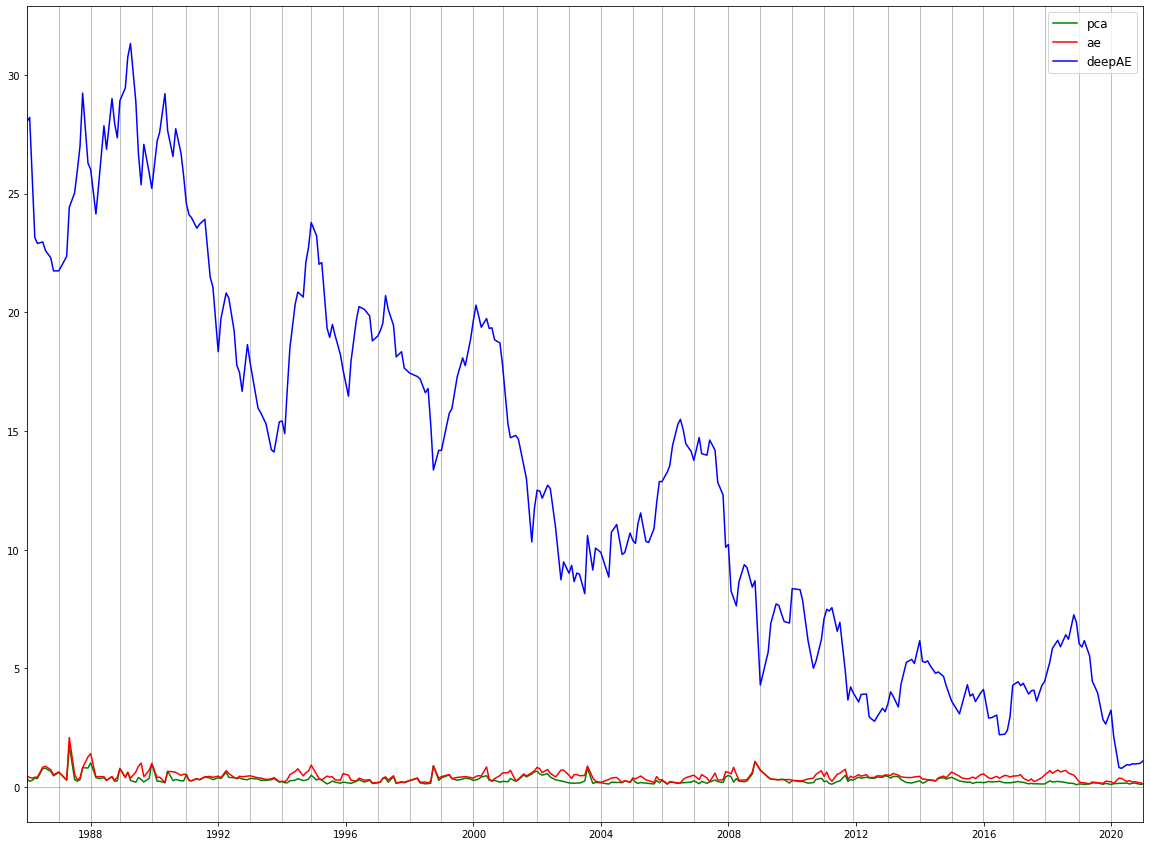

In [56]:
plt.figure(figsize=(20, 15))
plt.plot(df.index, pca_rec_errs, c='green')
plt.plot(df.index, ae_rec_errs, c='red')
plt.plot(df.index, deep_rec_errs, c='blue')
plt.legend(['pca','ae','deepAE'], fontsize=12)
plt.xlim(df.index.min(), df.index.max())
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i, 1, 1)) - 1],
                c="grey", linewidth=0.5, zorder=0)